Almacenado y recuperación de modelos --- 28:35 min
===

* Última modificación: Mayo 5, 2021 | [YouTube](https://youtu.be/Hhav7SEhFBA)

Adaptado de:

* https://www.tensorflow.org/tutorials/keras/save_and_load

En esta lección se explica como almacenar un modelo durante y al final del proceso de entrenamiento, y luego recuperarlo para su uso en productivo.

## Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.5.0


## Carga y configuración del dataset MNIST

In [2]:
#
# Esta es una base de datos de dígitos escritos
# a mano.
#
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist
#
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

#
# Usa los primeros 1000 patrones de los conjuntos
# de entrenamiento y prueba
#
train_images = train_images[:1000]
train_labels = train_labels[:1000]

test_images = test_images[:1000]
test_labels = test_labels[:1000]

11493376/11490434 [==============================] - 1s 0us/step


## Visualización de las imágenes

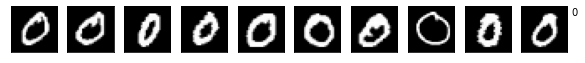

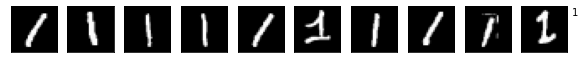

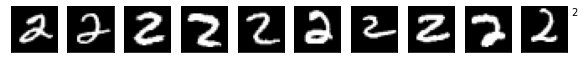

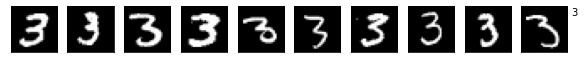

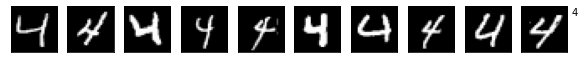

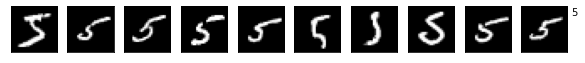

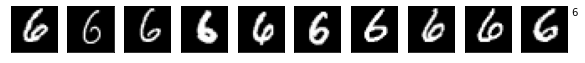

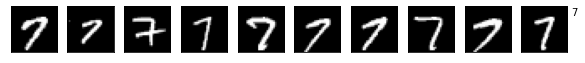

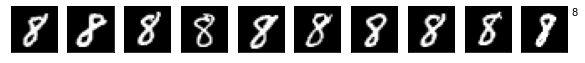

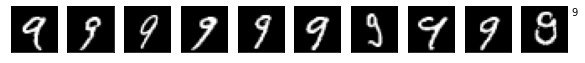

In [3]:
#
# Ejemplos de las figuras que contiene el dataset
#
def plot_mnist_examples(images, labels):
        
    #
    # Las figuras son de 28x28 pixels, y el
    # color va enntre 0 y 255. Se realiza la 
    # normalización del color al rango [0, 1]
    #
    images = images / 255.0
    
    data = [(img, lbl) for img, lbl in zip(images, labels)]
    for i in range(10):
        plt.figure(figsize=(10, 10))
        x = [(img, lbl)  for img, lbl in data if lbl == i]       
        for j in range(10):
            plt.subplot(10, 10, i*10 + 1 + j)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(1 - x[j][0], cmap=plt.cm.binary)
        plt.text(30, 5, str(i))


plot_mnist_examples(train_images, train_labels)

## Creación del modelo

In [4]:
def create_model():
    model = keras.models.Sequential(
        [
            #
            # Esta capa reduce una dimension de la matriz de entrada.
            # El conjunto de entrada es una lista de matrices de 28x28.
            # Flatten genera una lista de vectores de dimensión 28x28
            #            
            keras.layers.Flatten(input_shape=(28, 28)),
            
            #
            # Preprocesamiento de la entrada [0, 255] --> [0, 1]
            #
            keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255),
            
            #
            # Capa (oculta) de procesamiento
            #
            keras.layers.Dense(
                512,
                activation="relu",
            ),
            
            #
            # Aleatoriamente fija elementos en cero
            # para evitar el sobreentrenamiento
            #
            keras.layers.Dropout(0.2),
            
            #
            # Capa de salida
            #
            keras.layers.Dense(10),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
    )

    return model


#
# Crea una instancia del modelo
#
model = create_model()

#
# Arquitectura del modelo
#
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
rescaling (Rescaling)        (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Almacenamiento de los resultados parciales

In [5]:
checkpoint_dir = "/tmp/training_1/"
checkpoint_path = checkpoint_dir + "cp.ckpt"

#
# Borra la carpeta si existe
#
!rm -rf {checkpoint_dir}

#
# Crea un callback para guardar los pesos del modelo
# durante y al final del entrenamiento
#
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
)

#
# Entrenamiento del modelo
#
_ = model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[cp_callback],
)  

Epoch 1/10
32/32 [==============================] - 1s 9ms/step - loss: 1.1525 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.7820

Epoch 00001: saving model to /tmp/training_1/cp.ckpt
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.4187 - sparse_categorical_accuracy: 0.8840 - val_loss: 0.5279 - val_sparse_categorical_accuracy: 0.8310

Epoch 00002: saving model to /tmp/training_1/cp.ckpt
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.4716 - val_sparse_categorical_accuracy: 0.8510

Epoch 00003: saving model to /tmp/training_1/cp.ckpt
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8710

Epoch 00004: saving model to /tmp/training_1/cp.ckpt
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 

In [6]:
#
# Contenido del directorio
#
!ls -1 {checkpoint_dir}

checkpoint
cp.ckpt.data-00000-of-00001
cp.ckpt.index


## Recuperación de los pesos almacenados en disco

In [7]:
#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Métricas de la nueva instancia (modelo no entrenado)
# (loss, acc)
#
model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 2.3716 - sparse_categorical_accuracy: 0.0650


[2.371553659439087, 0.06499999761581421]

In [8]:
# 
# Lee los pesos almacenados en el disco duro
#
model.load_weights(checkpoint_path)

#
# Métricas de la nueva instancia con los
# pesos almacenados en disco
# (loss, acc)
#
model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4061 - sparse_categorical_accuracy: 0.8620


[0.4060852527618408, 0.8619999885559082]

## Personalización de los nombres de archivos y almacenamiento checkpoints

In [9]:
#
# Se especifica una nueva carpeta para almacenar
# los resultados y se personaliza el nombre
#
checkpoint_dir = "/tmp/training_2/"
checkpoint_path = checkpoint_dir + "cp-{epoch:04d}.ckpt"

#
# Borra la carpeta si existe
#
!rm -rf {checkpoint_dir}


BATCH_SIZE = 32

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    #
    # Salva el modelo cada 5 epochs
    #
    save_freq=5 * BATCH_SIZE,
)

#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Salva los pesos del modelo sin entrenar
#
model.save_weights(checkpoint_path.format(epoch=0))

#
# Entrenamiento del modelo
#
_ = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[cp_callback],
    validation_data=(test_images, test_labels),
    verbose=0,
)


Epoch 00005: saving model to /tmp/training_2/cp-0005.ckpt

Epoch 00010: saving model to /tmp/training_2/cp-0010.ckpt

Epoch 00015: saving model to /tmp/training_2/cp-0015.ckpt

Epoch 00020: saving model to /tmp/training_2/cp-0020.ckpt

Epoch 00025: saving model to /tmp/training_2/cp-0025.ckpt

Epoch 00030: saving model to /tmp/training_2/cp-0030.ckpt

Epoch 00035: saving model to /tmp/training_2/cp-0035.ckpt

Epoch 00040: saving model to /tmp/training_2/cp-0040.ckpt

Epoch 00045: saving model to /tmp/training_2/cp-0045.ckpt

Epoch 00050: saving model to /tmp/training_2/cp-0050.ckpt


In [10]:
#
# Contenido del directorio
#
!ls -1 {checkpoint_dir}

checkpoint
cp-0000.ckpt.data-00000-of-00001
cp-0000.ckpt.index
cp-0005.ckpt.data-00000-of-00001
cp-0005.ckpt.index
cp-0010.ckpt.data-00000-of-00001
cp-0010.ckpt.index
cp-0015.ckpt.data-00000-of-00001
cp-0015.ckpt.index
cp-0020.ckpt.data-00000-of-00001
cp-0020.ckpt.index
cp-0025.ckpt.data-00000-of-00001
cp-0025.ckpt.index
cp-0030.ckpt.data-00000-of-00001
cp-0030.ckpt.index
cp-0035.ckpt.data-00000-of-00001
cp-0035.ckpt.index
cp-0040.ckpt.data-00000-of-00001
cp-0040.ckpt.index
cp-0045.ckpt.data-00000-of-00001
cp-0045.ckpt.index
cp-0050.ckpt.data-00000-of-00001
cp-0050.ckpt.index


## Recuperación de los pesos a partir de un checkpoint

In [11]:
#
# Es posible obtener el nombre del ultimo checkpoint
#
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/tmp/training_2/cp-0050.ckpt'

In [12]:
#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Carga los pesos almacenados en el ultimo checkpoint
#
model.load_weights(latest)

#
# Métricas de la nueva instancia con los pesos almacenados 
# en el checkpoint (loss, acc)
#
model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4935 - sparse_categorical_accuracy: 0.8730


[0.4935464560985565, 0.8730000257492065]

## Almacenamiento y recuperación manual de los pesos de un modelo

In [13]:
#
# Salva los pesos a una carpeta
# (borra la carpeta si existe)
#
!rm -rf /tmp/checkpoints
model.save_weights("/tmp/checkpoints/my_checkpoint")

#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Carga los pesos
#
model.load_weights("/tmp/checkpoints/my_checkpoint")

#
# Métricas de evaluación
#
model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4935 - sparse_categorical_accuracy: 0.8730


[0.4935464560985565, 0.8730000257492065]

## Almacenamiento manual del modelo completo con SaveModel

In [14]:
#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Entrenamiento
#
model.fit(train_images, train_labels, epochs=5,)

#
# Crea la carpeta para almacenar el modelo
#
!mkdir -p /tmp/saved_complete_model/

#
# Salva el modelo
#
!rm -rf /tmp/saved_complete_model/
model.save("/tmp/saved_complete_model/my_model")

Epoch 1/5
32/32 [==============================] - 1s 3ms/step - loss: 1.1571 - sparse_categorical_accuracy: 0.6680
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8710
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2781 - sparse_categorical_accuracy: 0.9300
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9420
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9650
INFO:tensorflow:Assets written to: /tmp/saved_complete_model/my_model/assets


In [15]:
# 
# Contenido de la carpeta
#
!ls /tmp/saved_complete_model/

my_model


In [16]:
# 
# Contenido de la carpeta
#
!ls /tmp/saved_complete_model/my_model

assets	keras_metadata.pb  saved_model.pb  variables


In [17]:
#
# Carga el modelo desde el disco
#
new_model = tf.keras.models.load_model("/tmp/saved_complete_model/my_model")

#
# Resumen
#
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [18]:
#
# Métricas
#
new_model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4127 - sparse_categorical_accuracy: 0.8710


[0.41273897886276245, 0.8709999918937683]

In [19]:
#
# Evalua el conjunto de test con el modelo
# cargado de disco
#
new_model.predict(test_images).shape

(1000, 10)

## Almacenamiento del modelo completo en HDF5

In [20]:
#
# Crea una nueva instancia del modelo
#
model = create_model()

#
# Entrenamiento del modelo
#
model.fit(train_images, train_labels, epochs=5,)

#
# Salva el modelo en formato HDF5 
#
model.save("/tmp/my_model.h5")

Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 1.1942 - sparse_categorical_accuracy: 0.6550
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.4457 - sparse_categorical_accuracy: 0.8700
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2768 - sparse_categorical_accuracy: 0.9350
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9520
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.9610


In [21]:
#
# Crea un nuevo modelo a partir de la información
# almacenada en disco
#
new_model = tf.keras.models.load_model("/tmp/my_model.h5")

#
# Resumen del modelo
#
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [22]:
#
# Métricas de precisión
#
new_model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4287 - sparse_categorical_accuracy: 0.8490


[0.428665429353714, 0.8489999771118164]